In [15]:
import __future__
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from numpy import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def sig(z):
    """Sigmoid function."""
    return (1.0 / (1.0 + np.exp(-z)))

def d_sig(z):
    """First derivative of the sigmoid function."""
    return (sig(z) * (1 - sig(z)))

def inv_sig(x):
    """Inverse of the sigmoid function."""
    return np.array([np.log(1 / (1/xi - 1)) for xi in x])

In [3]:
def lin(z):
    """Linear function."""
    return (z)

def d_lin(z):
    """First derivative of the linear function."""
    return(1)

def inv_lin(x):
    """Inverse of the linear function."""
    return (x)

In [4]:
def lrelu(z, leak = 0.01):
    """Leaky rectified linear unit (leaky ReLU)."""
    z[z < 0] *= leak
    return(z)

def d_lrelu(z, leak = 0.01):
    """First derivative of the leaky ReLU function,
    which can be represented by the Heaviside step function."""
    z[z >= 0] = 1
    z[z < 0] = leak
    return(z)

def inv_lrelu(x, leak = 0.01):
    """Inverse of the leaky ReLU function.""" 
    x[x < 0] *= 1/leak
    return(x)

In [73]:
class ArtificialNeuralNetwork(object):
    """An artificial neural network."""
    
    def __init__(self, layers, cross_entropy = False, act = sig, d_act = d_sig, inv_act = inv_sig):
        """Initialize the ANN class by randomizing all the
        weights and biases in the network.
        
        `layers`: (list) list whose elements are the number of neurons in each
        layer; (list of integers)
        
        `num_layers`: (integer) number of layers in the network including 
        input layer, given by the length of `layers` list.
        
        `biases`: (list) list of column vectors containing randomized biases.
        No biases for the 0th (input) layer; (list of arrays)
        
        `weights`: (list) list of matrices containing randomized weights.
        The matrix dimensions are (ml, ml_1), where ml is the number of 
        neurons in the next/terminal layer and ml_1 (em el minus one) is the 
        number of neurons in the previous/initial layer; (list of arrays)"""
        
        self.layers = layers
        self.num_layers = len(layers)
        self.biases = [random.randn(ml, 1) for ml in layers[1:]]  
        self.weights = [random.randn(ml, ml_1)/np.sqrt(ml_1)
                        for (ml, ml_1) in zip(layers[1:], layers[:-1])]  # implemented weight initialization
        self.cross_entropy = cross_entropy
        self.act = act
        self.d_act = d_act
        self.inv_act = inv_act
    
    
    def feedforward(self, x):
        """Secondly, define the input values and feed them forward. This
        function returns the activation values and weighted inputs of the 
        next layer given the weighted input values of the previous layer,
        which is `x`. Done by using the sigmoid activation function.
        
        `x`: (array) input values of the first layer."""
        
        weighted_inputs = []
        activations = [x]
        
        for (b, w) in zip(self.biases, self.weights):
            z = np.dot(w, x) + b
            x = self.act(z)
            weighted_inputs.append(z)
            activations.append(x)
            
        return (weighted_inputs, activations)
    
    
    def cost_derivative(self, xL, y):
        """After feeding forward, we will have activation values of all
        the layers. This function returns the derivative of the cost 
        function with respect to the output activation in the last layer. 
        
        `xL`: (array) should ONLY be activation values of the last layer.
        
        `y`: (array) target output values."""
        
        #if self.cross_entropy:
        #    return ((xL - y) / (xL*(1 - xL)))
        #else:
        return (xL - y)
    
    
    def backpropagate(self, x, y):
        """Using the weighted inputs and activation values from feeding 
        forward, we now backpropagate the errors from each layer, starting
        from the last layer. After the errors are backpropagated, the 
        gradients of cost with respect to each weight and bias is computed.
        The function then returns the two lists of gradients as a tuple.
        
        `x`: (array) input values of the first layer.
        
        `y`: (array) target output values."""
        
        (Z, X) = self.feedforward(x)
        L = self.num_layers - 1  # python's index of the last layer, first layer is 0th layer
        gradients_b = [np.zeros(b.shape) for b in self.biases]
        gradients_w = [np.zeros(w.shape) for w in self.biases]
        
        grad_xL = self.cost_derivative(X[L], y)
        
        if self.cross_entropy:
            delta_l = grad_xL
        else:
            dsig_zL = self.d_act(Z[L-1])
            delta_l = grad_xL * dsig_zL # compute output error ; numpy multiplication is elementwise
            
        grad_wL = np.dot(delta_l, X[L-1].transpose())
        
        gradients_b[L-1] = delta_l
        gradients_w[L-1] = grad_wL
        
        for l in range(L-1,0,-1): # backpropagate the error, starting from the second last layer
            
            dsig_zl = self.d_act(Z[l-1])
            delta_l = np.dot(self.weights[l].transpose(), delta_l) * dsig_zl    
            grad_wl = np.dot(delta_l, X[l-1].transpose())
            
            gradients_b[l-1] = delta_l
            gradients_w[l-1] = grad_wl
        
        return(gradients_b, gradients_w)
    
    
    def SGD(self, mini_batch, alpha, lmbda, n):
        """Using the gradients calculated from the backpropagation problem,
        we apply one step of the stochastic gradient descent algorithm to a
        single mini-batch of data.
        
        `mini_batch`: (list of tuples)
        
        `alpha`: (integer) learning rate."""
        
        grad_b_sum = [np.zeros(b.shape) for b in self.biases]
        grad_w_sum = [np.zeros(w.shape) for w in self.weights]
        
        for (qx, qy) in mini_batch:  # here, a matrix-based approach can be taken
            (grad_bq, grad_wq) = self.backpropagate(qx, qy)
            grad_b_sum = [gb + gbq for (gb, gbq) in zip(grad_b_sum, grad_bq)]
            grad_w_sum = [gw + gwq for (gw, gwq) in zip(grad_w_sum, grad_wq)]
           
        new_biases = [b - (alpha / len(mini_batch)) * gbs  
                      for (b, gbs) in zip(self.biases, grad_b_sum)]
        new_weights = [(1 - alpha*lmbda/n)*w - (alpha / len(mini_batch)) * gws
                       for (w, gws) in zip(self.weights, grad_w_sum)]
        
        self.biases = new_biases
        self.weights = new_weights
        
        return([new_biases, new_weights])
        
        
    def evaluate(self, test):
        """Return the number of test inputs for which the neural network
        outputs the correct result. The neural network's output is 
        calculated by taking the index of the neuron with the highest
        activation value in the final layer.
        
        `test`: (list of tuples)"""
        
        test_results = [(self.feedforward(x)[1][-1], 
                         np.argmax(y)) for (x, y) in test]
    
        return (sum(int(np.argmax(xL) == yi) 
                    for (xL, yi) in test_results))
    
    
    def track_progress(self, train, mini_batch_size, alpha, epochs,
                       lmbda, test = None):
        """applies SGD over all batches and epochs
        
        `train`: (list of tuples)
        
        `mini_batch_size`: (integer)
        
        `alpha`: (integer)
        
        `epochs`: (integer)
        
        `test`: (list of tuples)."""
        
        wei = []
        bia = []
        if test: n_test = len(test)
        n = len(train)
        
        for j in range(epochs):  # change here to implement matrix-based approach
            random.shuffle(train)
            #random.shuffle(test)
            mini_batches = [train[k:k+mini_batch_size]
                            for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                sgd = self.SGD(mini_batch, alpha, lmbda, n)
                bia = sgd[0]
                wei = sgd[1]
                
            if test: # with %d(%g)%% confidence"
                print("Epoch %d: %d / %d"  % (j+1,
                      self.evaluate(test), n_test))
                    #, self.evaluate(test)[1], self.evaluate(test)[2]))
            else:
                print("Epoch %d complete" % (j+1,))
        
        return([bia, wei])
            #display(self.evaluate(test)[1])
    
    
    def collect_parameters(self, train, mini_batch_size, alpha, epochs, lmbda, test = None):
        
        
        tp = self.track_progress(train, mini_batch_size, alpha, epochs,
                       lmbda, test)
        
        self.bee = tp[0]
        self.Wu = tp[1]
        
    
    def write(self, number):
        
        
        L = self.num_layers - 1  
        condition = (np.arange(self.layers[-1]) == number)
        y0 = (condition * 1.).reshape(self.layers[-1],1)
        y = (condition * 1.).reshape(self.layers[-1],1)
        
        b = self.bee
        W = self.Wu
        
        for k in range(L-1,-1,-1):
            
            z = self.inv_act(y)
            inv_Wk = np.linalg.pinv(W[k])
            y = np.matmul(inv_Wk, (z - b[k]))
        
        y = y.reshape((28, 28))
        return(y)
    

In [74]:
# train scribe
scribe = ArtificialNeuralNetwork([784, 100, 10], cross_entropy = True, act = lrelu, d_act = d_lrelu, inv_act = inv_lrelu)

In [75]:
scribe.collect_parameters(train = mnist_train, mini_batch_size = 10, alpha = 0.1, epochs = 30, lmbda = 5.0, test = mnist_test)

Epoch 1: 9527 / 10000
Epoch 2: 9574 / 10000
Epoch 3: 9629 / 10000
Epoch 4: 9668 / 10000
Epoch 5: 9688 / 10000
Epoch 6: 9704 / 10000
Epoch 7: 9705 / 10000
Epoch 8: 9728 / 10000
Epoch 9: 9731 / 10000
Epoch 10: 9737 / 10000
Epoch 11: 9739 / 10000
Epoch 12: 9753 / 10000
Epoch 13: 9738 / 10000
Epoch 14: 9747 / 10000
Epoch 15: 9757 / 10000
Epoch 16: 9754 / 10000
Epoch 17: 9757 / 10000
Epoch 18: 9770 / 10000
Epoch 19: 9756 / 10000
Epoch 20: 9743 / 10000
Epoch 21: 9764 / 10000
Epoch 22: 9746 / 10000
Epoch 23: 9764 / 10000
Epoch 24: 9786 / 10000
Epoch 25: 9775 / 10000
Epoch 26: 9772 / 10000
Epoch 27: 9765 / 10000
Epoch 28: 9754 / 10000
Epoch 29: 9756 / 10000
Epoch 30: 9774 / 10000


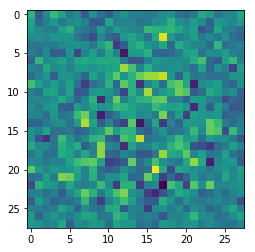

In [110]:
n = 0
plt.imshow((scribe.write(number = n) - np.mean(scribe.write(number = n))) / np.std(scribe.write(number = n)))

In [347]:
ann = ArtificialNeuralNetwork([3,4,10], cross_entropy = True, act = lin, d_act = d_lin, inv_act = inv_lin)

In [348]:
ann.write(number = 1)

array([[  1.68416171],
       [-21.42131728],
       [ -5.68693583]])

In [13]:
ann.biases

[array([[-0.90810384],
        [-0.49645192],
        [ 0.26527173],
        [ 0.45500425]]), array([[-0.38368716],
        [-0.99846356]])]

In [14]:
ann.weights

[array([[-0.65924387,  0.36517461,  1.13463437],
        [-1.09100389, -0.51929066, -0.02437729],
        [-0.14103196,  0.35366232, -0.24706775],
        [ 0.25404798, -0.48978494, -0.39120683]]),
 array([[-0.06468083,  0.19356078,  0.51588592, -0.07810771],
        [ 1.01984022, -0.70366111, -0.23453442,  0.85547845]])]

In [3]:
layers = [2, 8, 2]

In [4]:
annlogic = ArtificialNeuralNetwork(layers)

In [6]:
and_inp = [(np.array([[0],[0]]), np.array([[1],[0]])),
           (np.array([[0],[1]]), np.array([[0],[1]])),
           (np.array([[1],[0]]), np.array([[0],[1]])),
           (np.array([[1],[1]]), np.array([[1],[0]]))]

In [7]:
train_data = list()

In [8]:
test_data = list()

In [9]:
validation_data = list()

In [11]:
for j in range(80):
    for inp in and_inp:
        new_tup = tuple(inp)
        train_data.append(new_tup)

In [12]:
len(train_data)

320

In [13]:
len(test_data)

80

In [14]:
len(validation_data)

0

In [18]:
annlogic.track_progress(train = train_data, mini_batch_size = 2, alpha = 0.1, epochs = 100, test = test_data)

In [9]:
from tensorflow.examples.tutorials.mnist import input_data

In [10]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [24]:
# special dataset type
type(mnist)

tensorflow.contrib.learn.python.learn.datasets.base.Datasets

In [25]:
mnist.train.images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [29]:
# 55000 images and 784 pixels in each image
# each image is places as a row
mnist.train.images.shape

(55000, 784)

In [30]:
mnist.train.num_examples

55000

In [32]:
# 10000 test examples
mnist.test.num_examples

10000

In [55]:
# can understand images like this ; grab the 1st image and reshape into 28x28
mnist.train.images[1].reshape((28,28))

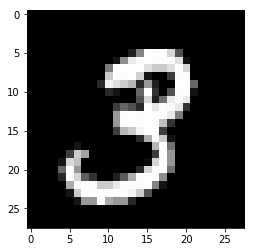

In [52]:
# then call the imshow() method from matplotlib
# and then change colormap into greyscale
plt.imshow(mnist.train.images[1].reshape((28,28)), cmap = 'gist_gray')

In [53]:
type(mnist.train.images)

numpy.ndarray

In [57]:
mnist.train.labels.shape

(55000, 10)

In [58]:
mnist.train.images.shape

(55000, 784)

In [61]:
mnist.test.images.shape

(10000, 784)

In [62]:
mnist.test.labels.shape

(10000, 10)

## process raw data into train and test lists of tuples

In [89]:
a = np.array([[1,2,3],
              [4,5,6],
              [7,8,9],
              [10,11,12],
              [13,14,15]])
b = np.array([[11,22],
              [33,44],
              [55,66],
              [77,88],
              [99,101]])

In [90]:
a.shape[1]

3

In [91]:
emp_lis = []

In [92]:
for (ai,bi) in zip(a,b):
    emp_lis.append((ai.reshape(3,1),
                    bi.reshape(2,1)))
emp_lis

[(array([[1],
         [2],
         [3]]), array([[11],
         [22]])), (array([[4],
         [5],
         [6]]), array([[33],
         [44]])), (array([[7],
         [8],
         [9]]), array([[55],
         [66]])), (array([[10],
         [11],
         [12]]), array([[77],
         [88]])), (array([[13],
         [14],
         [15]]), array([[ 99],
         [101]]))]

In [11]:
def process_data(data_inputs, data_labels):
    """Function to package data into a list of tuples
    consisting of input data and target output arrays. 
    Returns a list of data tuples.
    
    `data_inputs`: (2D array)
    
    `data_labels`: (2D array)."""
    
    input_col = data_inputs.shape[1]
    label_col = data_labels.shape[1]
    data_list = []
    
    for (di,dl) in zip(data_inputs, data_labels):
        data_list.append((di.reshape(input_col,1),
                          dl.reshape(label_col,1)))
    
    return (data_list)

### process training images

In [12]:
train_images = mnist.train.images
train_labels = mnist.train.labels

mnist_train = process_data(train_images, train_labels)

### process test images

In [13]:
test_images = mnist.test.images
test_labels = mnist.test.labels

mnist_test = process_data(test_images, test_labels)

### process validation images

In [14]:
validation_images = mnist.validation.images
validation_labels = mnist.validation.labels

mnist_validation = process_data(validation_images, test_labels)

### run the ANN

In [107]:
ann_mnist = ArtificialNeuralNetwork([784, 30, 10])

In [108]:
ann_mnist.track_progress(train = mnist_train, mini_batch_size = 10, alpha = 3.0, epochs = 30, test = mnist_test)

Epoch 0: 9113 / 10000
Epoch 1: 9221 / 10000
Epoch 2: 9330 / 10000
Epoch 3: 9385 / 10000
Epoch 4: 9410 / 10000
Epoch 5: 9403 / 10000
Epoch 6: 9429 / 10000
Epoch 7: 9415 / 10000
Epoch 8: 9445 / 10000
Epoch 9: 9457 / 10000
Epoch 10: 9448 / 10000
Epoch 11: 9487 / 10000
Epoch 12: 9457 / 10000
Epoch 13: 9495 / 10000
Epoch 14: 9470 / 10000
Epoch 15: 9475 / 10000
Epoch 16: 9470 / 10000
Epoch 17: 9500 / 10000
Epoch 18: 9496 / 10000
Epoch 19: 9507 / 10000
Epoch 20: 9490 / 10000
Epoch 21: 9499 / 10000
Epoch 22: 9491 / 10000
Epoch 23: 9499 / 10000
Epoch 24: 9511 / 10000
Epoch 25: 9492 / 10000
Epoch 26: 9485 / 10000
Epoch 27: 9515 / 10000
Epoch 28: 9486 / 10000
Epoch 29: 9525 / 10000


#### 1. peak accuracy 95.25% when run on a [784, 30, 10] network

In [109]:
ann_mnist2 = ArtificialNeuralNetwork([784, 100, 10])

In [110]:
ann_mnist2.track_progress(train = mnist_train, mini_batch_size = 10, alpha = 3.0, epochs = 30, test = mnist_test)

Epoch 0: 6681 / 10000
Epoch 1: 7504 / 10000
Epoch 2: 8427 / 10000
Epoch 3: 8490 / 10000
Epoch 4: 8541 / 10000
Epoch 5: 8591 / 10000
Epoch 6: 8596 / 10000
Epoch 7: 9521 / 10000
Epoch 8: 9533 / 10000
Epoch 9: 9584 / 10000
Epoch 10: 9573 / 10000
Epoch 11: 9601 / 10000
Epoch 12: 9604 / 10000
Epoch 13: 9625 / 10000
Epoch 14: 9630 / 10000
Epoch 15: 9634 / 10000
Epoch 16: 9634 / 10000
Epoch 17: 9640 / 10000
Epoch 18: 9658 / 10000
Epoch 19: 9654 / 10000
Epoch 20: 9652 / 10000
Epoch 21: 9655 / 10000
Epoch 22: 9655 / 10000
Epoch 23: 9661 / 10000
Epoch 24: 9662 / 10000
Epoch 25: 9666 / 10000
Epoch 26: 9672 / 10000
Epoch 27: 9678 / 10000
Epoch 28: 9671 / 10000
Epoch 29: 9673 / 10000


#### 2. peak accuracy 96.78% when run on a [784, 100, 10] network

In [111]:
ann_mnist3 = ArtificialNeuralNetwork([784, 10])

In [112]:
ann_mnist3.track_progress(train = mnist_train, mini_batch_size = 10, alpha = 3.0, epochs = 30, test = mnist_test)

Epoch 0: 6444 / 10000
Epoch 1: 7172 / 10000
Epoch 2: 7221 / 10000
Epoch 3: 7250 / 10000
Epoch 4: 7219 / 10000
Epoch 5: 7264 / 10000
Epoch 6: 7262 / 10000
Epoch 7: 7280 / 10000
Epoch 8: 7272 / 10000
Epoch 9: 7282 / 10000
Epoch 10: 7269 / 10000
Epoch 11: 7291 / 10000
Epoch 12: 7270 / 10000
Epoch 13: 7297 / 10000
Epoch 14: 7285 / 10000
Epoch 15: 7285 / 10000
Epoch 16: 7273 / 10000
Epoch 17: 7290 / 10000
Epoch 18: 7277 / 10000
Epoch 19: 7293 / 10000
Epoch 20: 7287 / 10000
Epoch 21: 7294 / 10000
Epoch 22: 7299 / 10000
Epoch 23: 7313 / 10000
Epoch 24: 7272 / 10000
Epoch 25: 7285 / 10000
Epoch 26: 7281 / 10000
Epoch 27: 7270 / 10000
Epoch 28: 7289 / 10000
Epoch 29: 7306 / 10000


#### 3. peak accuracy 73.13% when run on a [784, 10] network

In [116]:
ann_mnist4 = ArtificialNeuralNetwork([784, 200, 150, 100, 10]) 

## WARNING: very long execution time, takes 2.5 min per epoch

In [117]:
ann_mnist4.track_progress(train = mnist_train, mini_batch_size = 10, alpha = 3.0, epochs = 30, test = mnist_test)

Epoch 0: 7191 / 10000
Epoch 1: 7387 / 10000
Epoch 2: 8529 / 10000
Epoch 3: 8649 / 10000
Epoch 4: 8579 / 10000
Epoch 5: 8634 / 10000
Epoch 6: 8727 / 10000
Epoch 7: 8660 / 10000
Epoch 8: 8797 / 10000
Epoch 9: 9497 / 10000
Epoch 10: 9523 / 10000
Epoch 11: 9591 / 10000
Epoch 12: 9565 / 10000
Epoch 13: 9550 / 10000
Epoch 14: 9605 / 10000
Epoch 15: 9597 / 10000
Epoch 16: 9628 / 10000
Epoch 17: 9579 / 10000
Epoch 18: 9662 / 10000
Epoch 19: 9647 / 10000
Epoch 20: 9646 / 10000
Epoch 21: 9620 / 10000
Epoch 22: 9636 / 10000
Epoch 23: 9667 / 10000
Epoch 24: 9640 / 10000
Epoch 25: 9632 / 10000
Epoch 26: 9644 / 10000
Epoch 27: 9683 / 10000
Epoch 28: 9661 / 10000
Epoch 29: 9698 / 10000


#### 4. peak accuracy 96.98% when run on a [784, 200, 150, 100, 10] network

For practical purposes, use a [784, 100, 10] network.

In [118]:
ann_mnist5 = ArtificialNeuralNetwork([784, 100, 10])

In [119]:
ann_mnist5.track_progress(train = mnist_train, mini_batch_size = 32, alpha = 3.0, epochs = 30, test = mnist_test)

Epoch 0: 5408 / 10000
Epoch 1: 5619 / 10000
Epoch 2: 5675 / 10000
Epoch 3: 5716 / 10000
Epoch 4: 5736 / 10000
Epoch 5: 5742 / 10000
Epoch 6: 5763 / 10000
Epoch 7: 5774 / 10000
Epoch 8: 5777 / 10000
Epoch 9: 5783 / 10000
Epoch 10: 5790 / 10000
Epoch 11: 5793 / 10000
Epoch 12: 5794 / 10000
Epoch 13: 5801 / 10000
Epoch 14: 5813 / 10000
Epoch 15: 5807 / 10000
Epoch 16: 5817 / 10000
Epoch 17: 5900 / 10000
Epoch 18: 6703 / 10000
Epoch 19: 6718 / 10000
Epoch 20: 6723 / 10000
Epoch 21: 6722 / 10000
Epoch 22: 6731 / 10000
Epoch 23: 6719 / 10000
Epoch 24: 6744 / 10000
Epoch 25: 6744 / 10000
Epoch 26: 6743 / 10000
Epoch 27: 6758 / 10000
Epoch 28: 6749 / 10000
Epoch 29: 6748 / 10000


#### 5. peak accuracy 67.58% when run on a [784, 100, 10] network with a mini-batch size of 32

Start using 1000 train images and validation data (instead of test data) of 5000 images to tune the hyperparameters.

In [ ]:
ann_mnist7 = ArtificialNeuralNetwork([784, 100, 10])

In [ ]:
ann_mnist6.track_progress(train = mnist_train, mini_batch_size = 10, alpha = 3.0, epochs = 30,
                          test = mnist_validation)

Epoch 0: 494 / 5000
Epoch 1: 484 / 5000
Epoch 2: 486 / 5000
Epoch 3: 502 / 5000
Epoch 4: 493 / 5000
Epoch 5: 493 / 5000
Epoch 6: 498 / 5000
Epoch 7: 485 / 5000
Epoch 8: 485 / 5000
Epoch 9: 483 / 5000
Epoch 10: 489 / 5000
Epoch 11: 493 / 5000
Epoch 12: 496 / 5000
Epoch 13: 503 / 5000
Epoch 14: 495 / 5000
Epoch 15: 486 / 5000
Epoch 16: 480 / 5000
Epoch 17: 480 / 5000
Epoch 18: 490 / 5000
Epoch 19: 481 / 5000
Epoch 20: 494 / 5000
Epoch 21: 480 / 5000
Epoch 22: 486 / 5000
Epoch 23: 477 / 5000
Epoch 24: 488 / 5000
Epoch 25: 492 / 5000
Epoch 26: 491 / 5000
Epoch 27: 497 / 5000


In [22]:
ann_mnist1 = ArtificialNeuralNetwork([784, 30, 10])

In [23]:
ann_mnist1.track_progress(train = mnist_train, mini_batch_size = 10, alpha = 3.0, epochs = 30, test = mnist_test)

Epoch 0: 9156 / 10000
Epoch 1: 9175 / 10000
Epoch 2: 9352 / 10000
Epoch 3: 9341 / 10000
Epoch 4: 9396 / 10000
Epoch 5: 9416 / 10000
Epoch 6: 9428 / 10000
Epoch 7: 9434 / 10000
Epoch 8: 9404 / 10000
Epoch 9: 9449 / 10000
Epoch 10: 9463 / 10000
Epoch 11: 9512 / 10000
Epoch 12: 9495 / 10000
Epoch 13: 9487 / 10000
Epoch 14: 9501 / 10000
Epoch 15: 9495 / 10000
Epoch 16: 9507 / 10000
Epoch 17: 9510 / 10000
Epoch 18: 9528 / 10000
Epoch 19: 9509 / 10000
Epoch 20: 9505 / 10000
Epoch 21: 9523 / 10000
Epoch 22: 9522 / 10000
Epoch 23: 9518 / 10000
Epoch 24: 9499 / 10000
Epoch 25: 9510 / 10000
Epoch 26: 9512 / 10000
Epoch 27: 9543 / 10000
Epoch 28: 9508 / 10000
Epoch 29: 9523 / 10000


In [41]:
ann_mnisti = ArtificialNeuralNetwork([784, 30, 10], cross_entropy = True)

In [42]:
ann_mnisti.track_progress(train = mnist_train, mini_batch_size = 10, alpha = 0.5, epochs = 30, test = mnist_test)

Epoch 0: 9386 / 10000
Epoch 1: 9488 / 10000
Epoch 2: 9531 / 10000
Epoch 3: 9560 / 10000
Epoch 4: 9528 / 10000
Epoch 5: 9545 / 10000
Epoch 6: 9575 / 10000
Epoch 7: 9573 / 10000
Epoch 8: 9543 / 10000
Epoch 9: 9619 / 10000
Epoch 10: 9627 / 10000
Epoch 11: 9596 / 10000
Epoch 12: 9604 / 10000
Epoch 13: 9599 / 10000
Epoch 14: 9617 / 10000
Epoch 15: 9607 / 10000
Epoch 16: 9581 / 10000
Epoch 17: 9594 / 10000
Epoch 18: 9602 / 10000
Epoch 19: 9565 / 10000
Epoch 20: 9603 / 10000
Epoch 21: 9603 / 10000
Epoch 22: 9626 / 10000
Epoch 23: 9620 / 10000
Epoch 24: 9619 / 10000
Epoch 25: 9626 / 10000
Epoch 26: 9598 / 10000
Epoch 27: 9610 / 10000
Epoch 28: 9590 / 10000
Epoch 29: 9581 / 10000


In [39]:
ann_mnistl = ArtificialNeuralNetwork([784, 100, 10], cross_entropy = True)

In [40]:
ann_mnistl.track_progress(train = mnist_train, mini_batch_size = 10, alpha = 0.1, epochs = 60, lmbda = 5.0, test = mnist_test)

Epoch 1: 9300 / 10000
Epoch 2: 9487 / 10000
Epoch 3: 9556 / 10000
Epoch 4: 9612 / 10000
Epoch 5: 9632 / 10000
Epoch 6: 9676 / 10000
Epoch 7: 9691 / 10000
Epoch 8: 9705 / 10000
Epoch 9: 9707 / 10000
Epoch 10: 9728 / 10000
Epoch 11: 9739 / 10000
Epoch 12: 9741 / 10000
Epoch 13: 9733 / 10000
Epoch 14: 9741 / 10000
Epoch 15: 9739 / 10000
Epoch 16: 9761 / 10000
Epoch 17: 9772 / 10000
Epoch 18: 9765 / 10000
Epoch 19: 9768 / 10000
Epoch 20: 9766 / 10000
Epoch 21: 9771 / 10000
Epoch 22: 9773 / 10000
Epoch 23: 9771 / 10000
Epoch 24: 9783 / 10000
Epoch 25: 9774 / 10000
Epoch 26: 9787 / 10000
Epoch 27: 9784 / 10000
Epoch 28: 9784 / 10000
Epoch 29: 9786 / 10000
Epoch 30: 9780 / 10000
Epoch 31: 9791 / 10000
Epoch 32: 9788 / 10000
Epoch 33: 9796 / 10000
Epoch 34: 9789 / 10000
Epoch 35: 9789 / 10000
Epoch 36: 9786 / 10000
Epoch 37: 9797 / 10000
Epoch 38: 9792 / 10000
Epoch 39: 9795 / 10000
Epoch 40: 9792 / 10000
Epoch 41: 9788 / 10000
Epoch 42: 9794 / 10000
Epoch 43: 9799 / 10000
Epoch 44: 9790 / 100

## max 98.04% accuracy with cross-entropy, weight-initialization, L2 regularization